# Parks and Public Transit Access in LA County

*Katrina Deloso & Ashley Yao*

**Introduction to our Research Question**

In this research project, we will analyze public transit access to 17 Regional Recreation Parks in LA County. We will examine which neighborhoods can access those recreation areas in a trip of 45 minutes or less of walking and public transit, and which forms of public transit are available to them. These 17 parks are the parks in LA County that each encompass over 100 acres and contain 3 or more active amenities, such as swimming pools or athletic fields.

We selected these parks because they draw users from across the county; sometimes drawing people from over 25 miles away. In this way, we’re using this definition of parks as a proxy for the most heavily used parks. Since users can live so far from these parks, they raise the question of how people get to the parks. Additionally, our research project has grown out of the LA Parks Needs Assessment project, which examined access to parks based on walking distance. That project inventoried over 3,000 parks and open spaces across the county, and divided them into four categories: Local Parks, Regional Recreation Parks, Regional Open Spaces, and Natural Areas. We selected the Regional Recreation Parks category for our analysis based on the reasoning above.

We will also be presenting census-tract level demographics on LA County; specifically, on race, income, and level of education. We want to examine whether there's a relationship between any of those demographics and access to parks.

Finally, we will aim to create a metric that measures the level of transit access to one or more of the regional parks, that we can assign to each census tract. This will likely be determined by measuring how many transit stops are available within the census tract that would take a rider to one or more of the 17 parks in less than 45 minutes total.

*Identification of Data Sources:*

* LA Metro: https://developer.metro.net/docs/gis-data/overview/
* LA County: County-wide Parks and Open Space: https://egis-lacounty.hub.arcgis.com/datasets/countywide-parks-and-open-space-public-hosted/
* LA County Park Needs: https://lacountyparkneeds.org/wp-content/uploads/2016/06/FinalReport.pdf
* Socrata
* Census Reporter
* https://www.ppic.org/content/pubs/cacounts/CC_206EBCC.pdf


*Importing Libraries*

In [1]:
# import libraries for: spatial data, plotting, network analysis, street network analysis, and basemaps

import urllib.request, json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import networkx as nx
import contextily as ctx
import plotly.express as px
from sodapy import Socrata

*Import Bus Data*

The bus stop data from LA Metro is imported, filtered, and analyzed to find drive sheds then walk sheds for Elysian Park.

In [2]:
bus = gpd.read_file('data/LineServingStops1219.shp')

**Line 4 Elysian Park**

Here we narrowed down the stops for Bus Route 2 and 4 which run adjacent to Elysian. Then turn the stop information into place values. Additionally we select one direction to reduce the number of isochrones needed. 

In [3]:
# narrowing down for Elysian route Lines 2 and 4 - these are the same along this section, so arbitrarily selected one.
busELY = bus.loc[bus['LINE']== 4]
busELY_sub = busELY[busELY['STOPNAME'].str.contains("SUNSET")]
busELY_subd = busELY_sub[busELY_sub['DIR_A2']=='E']
busELY_subd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17 entries, 2446 to 16288
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STOPNUM   17 non-null     int64   
 1   LINE      17 non-null     int64   
 2   DIR_A2    17 non-null     object  
 3   STOPNAME  17 non-null     object  
 4   LAT       17 non-null     float64 
 5   LONG      17 non-null     float64 
 6   geometry  17 non-null     geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 1.1+ KB


*Isochrone Map of Elysian Park LA Metro Route 2 Bus Stops*

Variables set and isogen function defined.

In [4]:
# variables set
# note to self: when you make drive isochrones for your buses make it about 15 minutes with 305 meters/min
network_type = 'walk'
trip_times = [15]
meters_per_minute = 75

In [5]:
#downloading street network
def isogen (gdf):
    global isochrones
    G = ox.graph.graph_from_point(center_point,dist = 2000, dist_type='bbox',
                              network_type='walk', simplify=True, retain_all=False, 
                              truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#project to web mercator
    G = ox.project_graph(G,to_crs='epsg:3857')

#convert nodes and edges to geodata frames
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
   
    # establishing centroid
    minx,miny,maxx,maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # selecting closest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # isochrone building
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times),
                                   cmap = 'plasma',
                                   start = 0,
                                   return_hex = True)
    trip_times.sort(reverse = True)
    time_color = list(zip(trip_times,iso_colors))
    time_color
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
    
    # legend
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G,center_node, radius = time, distance = 'time')
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time)+' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace = True)  
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns = ['time', 'geometry']
            

In [6]:
output = gpd.GeoDataFrame()
for index, row in busELY_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busELY_subd)
    output = isochrones.append(output, ignore_index=True)

*Plot Setup with Isochrones*

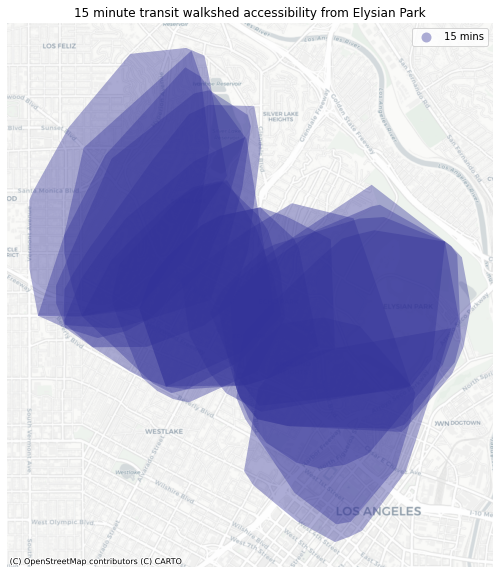

In [7]:
fig, ax = plt.subplots(figsize=(10,10))

output.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit walkshed accessibility from Elysian Park')
# Ashley assumed it would take 15 minutes to travel using bus exclusively along this one corridor

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

*List of Regional Recreation Parks*

1. Castiac Lake State Recreation Area, County of Los Angeles (Santa Clarita Transit)
2. Central Park, City of Santa Clarita (Santa Clarita Transit)
3. El Dorado Regional Park, Long Beach (Long Beach Transit)
4. Elysian Park, City of Los Angeles (analysis conducted above)
5. Ernest E. Debs Regional Park, City of Los Angeles
6. Frank Bonelli Regional Park, County of Los Angeles
7. Griffith Park, City of Los Angeles (analysis done by Katrina)
8. Hahamonga Watershed Park, City of Pasadena
9. Hansen Dam Park, City of Angeles
10. Heartwell Park, City of Long Beach
11. Ken Malloy Harbor Regional Park, City of Los Angeles
12. Kenneth Hahn State Recreation Area, County of Los Angeles
13. Peter F. Schabarum Regional County Park, County of Los Angeles
14. San Dimas Canyon Community Regional Park, County of Los Angeles
15. Santa Fe Dam Recreation Area, County of Los Angeles
16. Sepulveda Basin Recreation Area, City of Los Angeles
17. Whittier Narrows Recreation Area, County of Los Angeles

**Ernest E Debs Regional Park**

Analysis conducted for bus route 252 and 256. There is another route across the freeway, but we considered crossing a freeway to be inaccessible.

In [8]:
busEED1 = bus.loc[bus['LINE']== 252]
busEED1_sub = busEED1[busEED1['STOPNAME'].str.contains("MERCURY")]
busEED1_subd = busEED1_sub[busEED1_sub['DIR_A2']=='S']

In [9]:
busEED2 = bus.loc[bus['LINE']== 256]
busEED2_sub = busEED2[busEED2['STOPNAME'].str.contains("COLLIS")]
busEED2_subd = busEED1_sub[busEED1_sub['DIR_A2']=='N']

In [19]:
#still working on combinging these
#busEED = gpd.merge(busEED1_subd, busEED2_subd)
#busEED.head()

*Drive isochrone for Ernest E Debs Park*

In [11]:
# variables set
network_type = 'drive'
trip_times = [15] # made half estimated travel time in anticipation of slower buses
meters_per_minute = 305

In [12]:
#downloading street network
def isogen (gdf):
    global isochrones
    G = ox.graph.graph_from_point(center_point,dist = 2000, dist_type='bbox',
                              network_type='drive', simplify=True, retain_all=False, 
                              truncate_by_edge=False, clean_periphery=True, custom_filter=None)

#project to web mercator
    G = ox.project_graph(G,to_crs='epsg:3857')

#convert nodes and edges to geodata frames
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
   
    # establishing centroid
    minx,miny,maxx,maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    # selecting closest node
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    
    # isochrone building
    gdf_edges['drive_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times),
                                   cmap = 'plasma',
                                   start = 0,
                                   return_hex = True)
    trip_times.sort(reverse = True)
    time_color = list(zip(trip_times,iso_colors))
    time_color
    gdf_nodes,gdf_edges = ox.graph_to_gdfs(G)
    
    # legend
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G,center_node, radius = time, distance = 'time')
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time)+' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace = True)  
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns = ['time', 'geometry']
            

In [20]:
output1 = gpd.GeoDataFrame()
for index, row in busEED1_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busEED1_subd)
    output1 = isochrones.append(output, ignore_index=True)

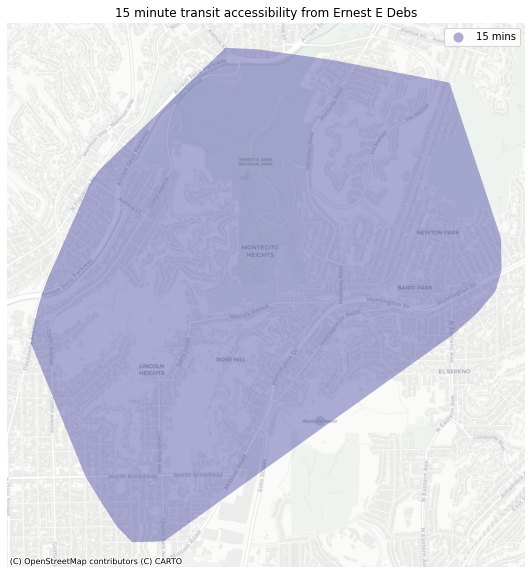

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

output1.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit accessibility from Ernest E Debs')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [22]:
output2 = gpd.GeoDataFrame()
for index, row in busEED2_subd.iterrows():
    center_point = row[4],row[5]
    isogen(busEED2_subd)
    output2 = isochrones.append(output, ignore_index=True)

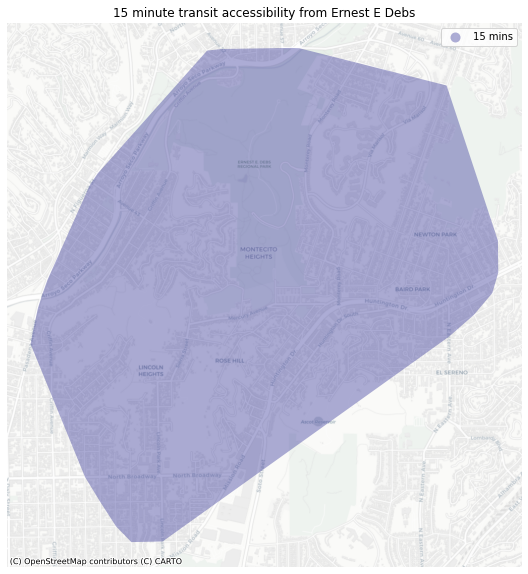

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

output2.plot(alpha=0.4, ax=ax, column='time', cmap='terrain', legend=True, zorder=20)

ax.axis('off')
ax.set_title('15 minute transit accessibility from Ernest E Debs')

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

*Extrapolating which Bus Stops fall into this region*

(Haven't figured out how to do this yet... or a way of consolidating all of the bus data/routes needed)

**Interactive Map of LA Red Line for Griffith Park** 

LA Metro API used to create an interactive map of Metro Line B (Red Line). 
I intended to show only the red line stops that are within 30 minutes of the Hollywood/Western stop, since we're capping our total travel time as 45 minutes to/from a park entrance, and there's a 15 minute walk from the station to the entrance However, after looking at the LA Metro timetables, I realized that Hollywood/Western is roughly in the middle of the red line, and all stops can be reached from it within 30 minutes. Because of this, I will include all red line stops

*Import LA Metro API*

In [2]:
# Call the LA metro API data for the red line, create a variable for it, and put it into a json file
metrorail_red = 'http://api.metro.net/agencies/lametro-rail/routes/802/stops/'
with urllib.request.urlopen(metrorail_red) as url:
    data = json.loads(url.read().decode())

# convert the data from json to a dataframe and specify that the contents will be the array called 'items'
df = pd.json_normalize(data, 'items')
df
# This dataframe shows the name, stop id, and lat/lon for all of the stops on the red line

id                                       display_name  latitude  \
0   80202                    Universal / Studio City Station  34.14000   
1   80214           Union Station - Metro Red & Purple Lines  34.05620   
2   80201                            North Hollywood Station  34.16850   
3   80208                          Vermont / Beverly Station  34.07653   
4   80212                            Pershing Square Station  34.04932   
5   80203                       Hollywood / Highland Station  34.10155   
6   80209                         Wilshire / Vermont Station  34.06270   
7   80206                           Vermont / Sunset Station  34.09771   
8   80207                     Vermont / Santa Monica Station  34.08991   
9   80211  7th Street / Metro Center Station - Metro Red ...  34.04863   
10  80204                           Hollywood / Vine Station  34.10163   
11  80205                        Hollywood / Western Station  34.10174   
12  80210                  Westlake / Macarthur Park Station  34.05637   
13  80213                  Civic Center / Grand Park Station  34.05490   

    longitude  
0  -118.36270  
1  -118.23425  
2  -118.37681  
3  -118.29169  
4  -118.25126  
5  -118.33855  
6  -118.29008  
7  -118.29176  
8  -118.29173  
9  -118.25868  
10 -118.32518  
11 -118.30812  
12 -118.27488  
13 -118.24606

*Converting DF to GDF and Webmercatoring*

In [3]:
gdf = gpd.GeoDataFrame(df, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf_web_mercator = gdf.to_crs(epsg=3857)

In [4]:
ctx.providers.OpenStreetMap.keys()

dict_keys(['Mapnik', 'DE', 'CH', 'France', 'HOT', 'BZH'])

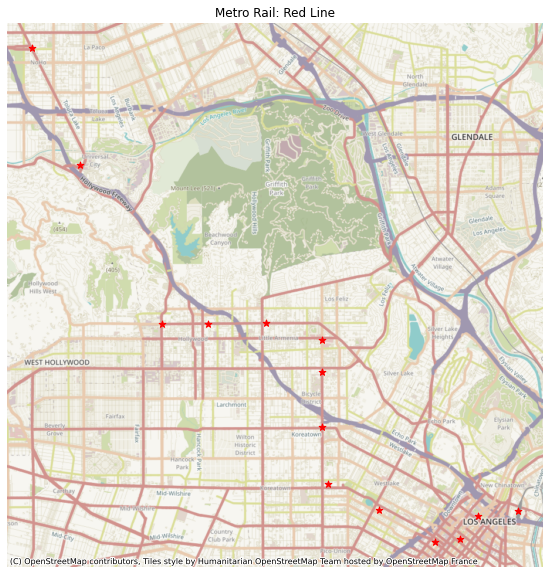

In [6]:
fig, ax = plt.subplots(figsize=(20,10))

gdf_web_mercator.plot(ax=ax, marker='*', markersize=50, color='red', edgecolor='red')

ax.axis('off')

ax.set_title('Metro Rail: Red Line')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

*Isolating Red Line*

In [12]:
metroportal = gpd.read_file('data/Portals_RedPurple_0715.shp')
metrostation = gpd.read_file('data/Stations_RedPurple_0715.shp')
metrostation['LINE']
metrostationred = metrostation.query("LINE == 'Red' | LINE == 'Red/Purple'")

In [13]:
metrored = metrostationred[['LINE','STATION','LAT','LONG','POINT_X','POINT_Y','geometry']].copy()

*Creating Interactive Map*

In [14]:
import folium

# center folium map at Hollywood/Western coordinates, since that's my area of study
mred = folium.Map(location=[34.101737, -118.308117], zoom_start=12)

# create for loop to create markers for each station
for index, row in metrored.iterrows():
    folium.Marker(
        location=[row.LAT,row.LONG], 
        tooltip=row.STATION, 
        icon=folium.Icon(color="red",icon="star"),
    ).add_to(mred)
mred

For the sake of memory, I have decided not to run the walkshed maps for this park. 

In [ ]:
#set variables
network_type = 'walk'
trip_times = [5, 10, 15] #in minutes
meters_per_minute = 75 # travel distance per minute

In [ ]:
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='walk')
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute
    
    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)
      
    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
  
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']
    #isochrones.plot(alpha=.2)
    
    fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
    gdf_edges.plot(ax=ax,
                   linewidth=0.5,
                   alpha = .2,
                   edgecolor='gainsboro', 
                   zorder=10)

# add all nodes to ax
    gdf_nodes.plot(ax=ax, 
                   markersize=1, 
                   zorder=10)

# add the center node in red
    gdf_nodes.loc[[center_node]].plot(ax=ax,
                                      color='r', 
                                      zorder=30)
# add isochrones
    isochrones.plot(alpha=.4,
                   ax=ax,
                   column='time',
                   cmap='viridis',
                   legend=True,
                   zorder=20)

# no axis
    ax.axis('off')

# title
###you can edit where this line draws the map title from
    ax.set_title('Walk sheds around Metro Red Line Stop: ' + row['STATION'])

    
# add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Voyager)

In [ ]:
for index,row in metrored.iterrows():
    place = (row['LAT'],row['LONG'])
    isomapred(metrored)

# Census Data

**Household Income by Census Tracts**

abbreviated version of Ashley's Week 3 work

In [15]:
gdf_HHinc = gpd.read_file('data/acs2019_5yr_B19001_14000US06037534001.geojson')

In [16]:
columns_to_keep = ['geoid','name',
 'B19001001',
 'B19001002',
 'B19001003',
 'B19001004',
 'B19001005',
 'B19001006',
 'B19001007',
 'B19001008',
 'B19001009',
 'B19001010',
 'B19001011',
 'B19001012',
 'B19001013',
 'B19001014',
 'B19001015',
 'B19001016',
 'B19001017',
 'geometry']

In [17]:
gdf_HHinc = gdf_HHinc[columns_to_keep]

In [18]:
gdf_HHinc.columns = ['geoid',
 'name','LA County, CA',
 'Less than $10,000',
 '$10,000 to $14,999',
 '$15,000 to $19,999',
 '$20,000 to $24,999',
 '$25,000 to $29,999',
 '$30,000 to $34,999',
 '$35,000 to $39,999',
 '$40,000 to $44,999',
 '$45,000 to $49,999',
 '$50,000 to $59,999',
 '$60,000 to $74,999',
 '$75,000 to $99,999',
 '$100,000 to $124,999',
 '$125,000 to $149,999',
 '$150,000 to $199,999',
 '$200,000 or more',
 'geometry']

In [21]:
gdf_HHinc['Percent Less than $10,000'] = gdf_HHinc['Less than $10,000']/gdf_HHinc['LA County, CA']*100
gdf_HHinc['$10,000 to $14,999'] = gdf_HHinc['$10,000 to $14,999']/gdf_HHinc['LA County, CA']*100
gdf_HHinc['$15,000 to $19,999'] = gdf_HHinc['$15,000 to $19,999']/gdf_HHinc['LA County, CA']*100
gdf_HHinc['$20,000 to $24,999'] = gdf_HHinc['$20,000 to $24,999']/gdf_HHinc['LA County, CA']*100
# etc...
gdf_HHinc['Percent $200,000 or more'] = gdf_HHinc['$200,000 or more']/gdf_HHinc['LA County, CA']*100

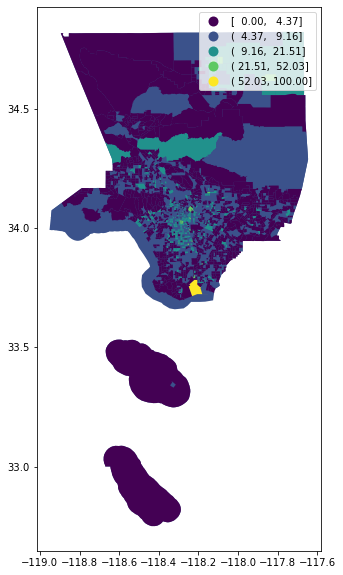

In [22]:
gdf_HHinc.plot(figsize=(12,10),
                 column='Percent Less than $10,000',
                 legend=True, 
                 scheme='NaturalBreaks')

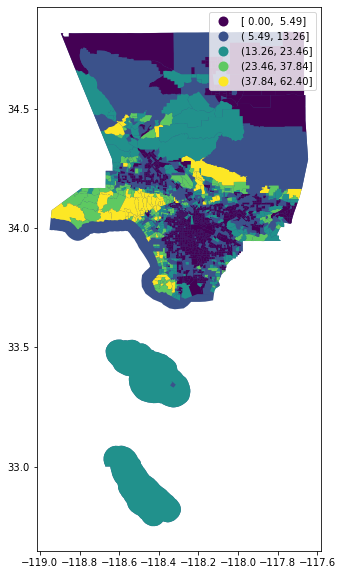

In [25]:
gdf_HHinc.plot(figsize=(12,10),
                 column='Percent $200,000 or more',
                 legend=True, 
                 scheme='NaturalBreaks')

**Education levels by Census Tract**

abbreviated version of Katrina's Week 3 work

In [29]:
gdf = gpd.read_file('data/acs2019_5yr_B15003_14000US06037534001.geojson')

In [30]:
gdf = gdf.drop([0])

In [31]:
columns_to_keep = ['geoid',
 'name',
'B15003001',
 'B15003009',
 'B15003010',
 'B15003011',
 'B15003012',
 'B15003013',
 'B15003014',
 'B15003015',
 'B15003016',
 'B15003017',
 'B15003018',
 'B15003019',
 'B15003020',
 'B15003021',
 'B15003022',
 'B15003023',
 'B15003024',
 'B15003025',
 'geometry']
gdf = gdf[columns_to_keep]

In [32]:
gdf.columns = ['geoid',
'name', 
'Total',
 '5th grade',
 '6th grade',
 '7th grade',
 '8th grade',
 '9th grade',
 '10th grade',
 '11th grade',
 '12th grade, no diploma',
 'Regular high school diploma',
 'GED or alternative credential',
 'Some college, less than 1 year',
 'Some college, 1 or more years, no degree',
 'Bachelors degree',
 'Associates degree',
 'Masters degree',
 'Professional school degree',
 'Doctorate degree',
 'geometry']

Text(0.5, 1.0, 'Tracts with the greatest number of Masters degrees')

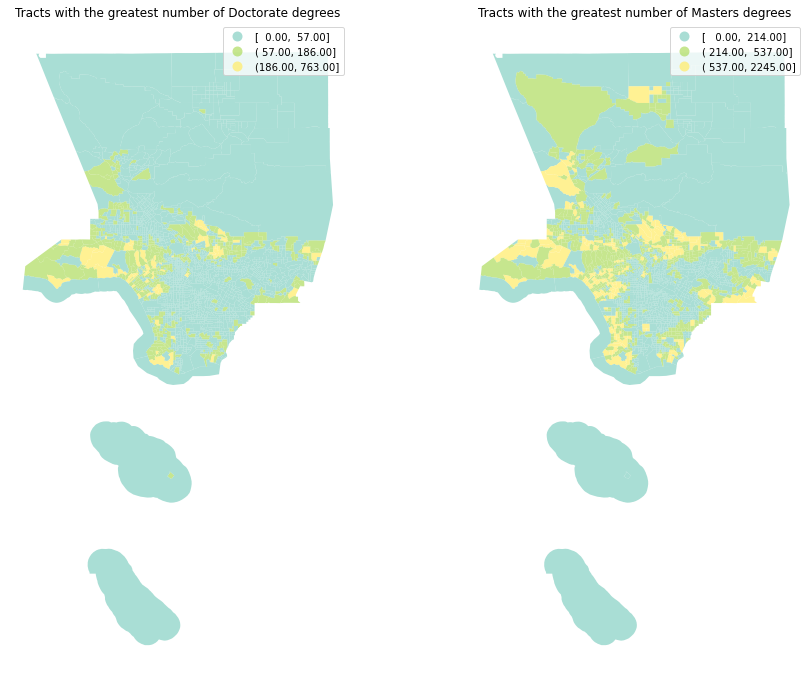

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(15, 12))

# name each subplot
ax1, ax2 = axs

#left map
gdf.plot(column='Doctorate degree',  
            cmap='Set3',
            scheme='NaturalBreaks',
            k=3, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot - ax=ax1 puts it on the left
            legend=True
           )

ax1.axis("off")
ax1.set_title("Tracts with the greatest number of Doctorate degrees")

# right map
gdf.plot(column='Masters degree', 
            cmap='Set3',
            scheme='NaturalBreaks',
            k=3, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot - ax=ax2 puts it on the right
            legend=True
           )

ax2.axis("off")
ax2.set_title("Tracts with the greatest number of Masters degrees")

**Race by Census Tract**

came from Yoh's work

# Park Information

**Bar Charts from Socrata Park descriptive Data**

In [34]:
metro_url = 'https://api.metro.net/agencies/lametro/routes/4/stops/'

with urllib.request.urlopen(metro_url) as url:
    data = json.loads(url.read().decode())
    
dfm = pd.json_normalize(data,'items')
dfm

id               display_name  latitude  longitude
0    16323          Sunset / Coronado  34.07953 -118.26875
1    14411    Santa Monica / Sweetzer  34.09084 -118.37062
2    02456                 Hill / 7th  34.04576 -118.25477
3    14414      Santa Monica / Virgil  34.09100 -118.28650
4    16304         Sunset / Echo Park  34.07707 -118.25771
..     ...                        ...       ...        ...
203  14398      Santa Monica / Hobart  34.09093 -118.30445
204  13596                 Hill / 4th  34.05044 -118.25041
205  06036      Santa Monica / Wilton  34.09064 -118.31373
206  14401     Santa Monica / La Brea  34.09085 -118.34457
207  16240  Santa Monica / La Cienega  34.08988 -118.37604

[208 rows x 4 columns]

In [35]:
# socrata
client = Socrata("data.lacity.org", None)
results = client.get("rwq7-yhp5", limit=2000)

# convert to pandas df
dfm = pd.DataFrame.from_records(results)
dfm.sample(3)

the_geom objectid  \
226  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      212   
112  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      100   
161  {'type': 'MultiPolygon', 'coordinates': [[[[-1...      152   

                        name_alpha     area_acres park_id cd_real name_publi  \
226    ROBERTSON RECREATION CENTER   1.2355762545     661      05        NaN   
112    EVERGREEN RECREATION CENTER  6.65637113022     867      14        NaN   
161  LEMON GROVE RECREATION CENTER  3.87147292089     239      13        NaN   

                              address region                           name  \
226        1641 S Pruess Rd, LA 90035      W    Robertson Recreation Center   
112           2839 E 4th St, LA 90033      M    Evergreen Recreation Center   
161  4959 W Lemon Grove Ave, LA 90029      M  Lemon Grove Recreation Center   

    issubpark park_class     shape_leng     shape_area  
226         N          C  1175.04742966  53821.4863595  
112         N          C  2481.04615545  289950.366627  
161         N          C  2106.53067045  168640.685869

In [39]:
RR = dfm.loc[dfm['park_class'] == 'R']
RR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 8 to 560
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   the_geom    119 non-null    object
 1   objectid    119 non-null    object
 2   name_alpha  119 non-null    object
 3   area_acres  119 non-null    object
 4   park_id     119 non-null    object
 5   cd_real     119 non-null    object
 6   name_publi  54 non-null     object
 7   address     119 non-null    object
 8   region      119 non-null    object
 9   name        119 non-null    object
 10  issubpark   119 non-null    object
 11  park_class  119 non-null    object
 12  shape_leng  119 non-null    object
 13  shape_area  119 non-null    object
dtypes: object(14)
memory usage: 13.9+ KB


Determining SubParks

In [40]:
px.bar(RR,
       x ='issubpark',
       title ='Are the parks inside another park?',
       labels = {'name_alpha': 'Park Name', 'park_id': 'Park ID#', 'area_acres': 'Area of Park'}
      )

Bad Chart Example due to excessive data

In [41]:
px.bar(RR,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')

Attempting to create a better graph by selecting parks of large areas

In [42]:
RR['acres'] = RR['area_acres'].astype(float)
RR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 8 to 560
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   the_geom    119 non-null    object 
 1   objectid    119 non-null    object 
 2   name_alpha  119 non-null    object 
 3   area_acres  119 non-null    object 
 4   park_id     119 non-null    object 
 5   cd_real     119 non-null    object 
 6   name_publi  54 non-null     object 
 7   address     119 non-null    object 
 8   region      119 non-null    object 
 9   name        119 non-null    object 
 10  issubpark   119 non-null    object 
 11  park_class  119 non-null    object 
 12  shape_leng  119 non-null    object 
 13  shape_area  119 non-null    object 
 14  acres       119 non-null    float64
dtypes: float64(1), object(14)
memory usage: 14.9+ KB


<ipython-input-42-76450f71a88a>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
RR_Big = RR.loc[RR['acres'] > 500]
px.bar(RR_Big,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')

The data above is too little. So let's try again by removing subparks.

In [44]:
RR_PA = RR.loc[RR['issubpark'] == 'N']
px.bar(RR_PA,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')

This only reduced the dataset by 4... so let's try larger than 100 acres

In [45]:
RR_PABig = RR_PA.loc[RR_PA['acres'] > 100]
px.bar(RR_PABig,
       x = 'name',
       y = 'area_acres',
      title = 'Areas of Parks')

I would like to sort these and there's a lot of other things we're working on! 